<a href="https://colab.research.google.com/github/Felista-Mueni/Felista-Mueni/blob/main/Predicting_employees_days_to_termination_using_GradientBoostingRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import pickle
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import loguniform, uniform, randint
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,precision_score,recall_score,average_precision_score,roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from pylab import rcParams
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/GDL - Cohort 18 Collaboration Drive/Project Files/C18 - 38 Supervised attrition models/Detailed data/'

In [ ]:
csv = "Detailed_Attrition_Data.csv"

In [ ]:
df = pd.read_csv(path + csv)
df = df.loc[df['Description'] == 0] ##only terminated for regression
df = df.drop(['DoW','Effective Date', 'ActivityDate', 'EndTimeInLocal','FileOrUrlName' ,'StartTimeInLocal','DepartmentName', 'ID', 'Description', 'isCore'], axis = 1)
df['Days to termination'] = df['Days to termination'].astype(int)
df['TeamName'] = df['TeamName'].apply(str)
df.head()

,Days to termination,LocationName,TeamName,JobFamilyName,ActivityTime,TimeSpent,"ActivityTime, Browsing","ActivityTime, Communication","ActivityTime, Documentation","ActivityTime, Email","ActivityTime, Meetings","ActivityTime, Miscellaneous","ActivityTime, Online Meetings","ActivityTime, Operations","ActivityTime, Private","ActivityTime, System Tools","ActivityTime, System Utilities","ActivityTime, Testing","ActivityTime, Unaccounted","ActivityTime, Work"
2410,204,Wisconsin,1179,Alternative Assets,0.012500,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012500
2411,204,Wisconsin,1179,Alternative Assets,0.004167,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004167
2412,204,Wisconsin,1179,Alternative Assets,0.020833,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833
2413,204,Wisconsin,1179,Alternative Assets,0.004167,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004167
2414,204,Wisconsin,1179,Alternative Assets,0.025000,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6670955 entries, 2410 to 10525718
Data columns (total 20 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Days to termination             int64  
 1   LocationName                    object 
 2   TeamName                        object 
 3   JobFamilyName                   object 
 4   ActivityTime                    float64
 5   TimeSpent                       float64
 6   ActivityTime, Browsing          float64
 7   ActivityTime, Communication     float64
 8   ActivityTime, Documentation     float64
 9   ActivityTime, Email             float64
 10  ActivityTime, Meetings          float64
 11  ActivityTime, Miscellaneous     float64
 12  ActivityTime, Online Meetings   float64
 13  ActivityTime, Operations        float64
 14  ActivityTime, Private           float64
 15  ActivityTime, System Tools      float64
 16  ActivityTime, System Utilities  float64
 17  ActivityTime, Testing  

In [ ]:
## DOWNCAST
int_cols = df.select_dtypes('integer').columns
float_cols = df.select_dtypes('float').columns

df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6670955 entries, 2410 to 10525718
Data columns (total 20 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Days to termination             int16  
 1   LocationName                    object 
 2   TeamName                        object 
 3   JobFamilyName                   object 
 4   ActivityTime                    float32
 5   TimeSpent                       float32
 6   ActivityTime, Browsing          float32
 7   ActivityTime, Communication     float32
 8   ActivityTime, Documentation     float32
 9   ActivityTime, Email             float32
 10  ActivityTime, Meetings          float32
 11  ActivityTime, Miscellaneous     float32
 12  ActivityTime, Online Meetings   float32
 13  ActivityTime, Operations        float32
 14  ActivityTime, Private           float32
 15  ActivityTime, System Tools      float32
 16  ActivityTime, System Utilities  float32
 17  ActivityTime, Testing  

In [ ]:
attrition = df.copy()

# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

In [ ]:
attrition_cat = attrition[categorical]
attrition_cat = pd.get_dummies(attrition_cat)
#attrition_cat.head(3)
attrition_num = attrition[numerical]
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1).fillna(0)

In [ ]:
attrition_final.shape

(6670955, 99)

In [ ]:
attrition_final.head()

,ActivityTime,"ActivityTime, Browsing","ActivityTime, Communication","ActivityTime, Documentation","ActivityTime, Email","ActivityTime, Meetings","ActivityTime, Miscellaneous","ActivityTime, Online Meetings","ActivityTime, Operations","ActivityTime, Private",...,JobFamilyName_Payment Services,JobFamilyName_Production Support,JobFamilyName_Recon Escalation and Reporting,JobFamilyName_Resolution Center,JobFamilyName_Retained Records,JobFamilyName_Statement Accounting,JobFamilyName_Strategy and Performance Optimization,JobFamilyName_Tax Services & Escheatment,JobFamilyName_Vault Services,JobFamilyName_WM Bus Technology Consultant
2410,0.012500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2411,0.004167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2412,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2413,0.004167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2414,0.025000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = attrition_final.drop(['Days to termination'], axis = 1) 
y = attrition_final[['Days to termination']]
y = y.values.ravel()

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
gb = GradientBoostingRegressor(n_estimators = 1000)
gb.fit(X_train,y_train)


GradientBoostingRegressor(n_estimators=1000)

In [ ]:
print("=====GradientBoostingRegressor=====")
print("Score Test:",gb.score(X_test,y_test))
pred_gb = gb.predict(X_test)
print("MAE:",mean_absolute_error(y_test,pred_gb))
print("MSE:",mean_squared_error(y_test,pred_gb))
print('R Squared:', r2_score(y_test,pred_gb))


=====GradientBoostingRegressor=====
Score Test: 0.3103419744361162
MAE: 69.3325130050548
MSE: 7589.087354728143
R Squared: 0.3103419744361162


In [ ]:
## save the model
with open('GBRTdetailmodel.pkl', 'wb') as model_file:
    pickle.dump(gb, model_file)

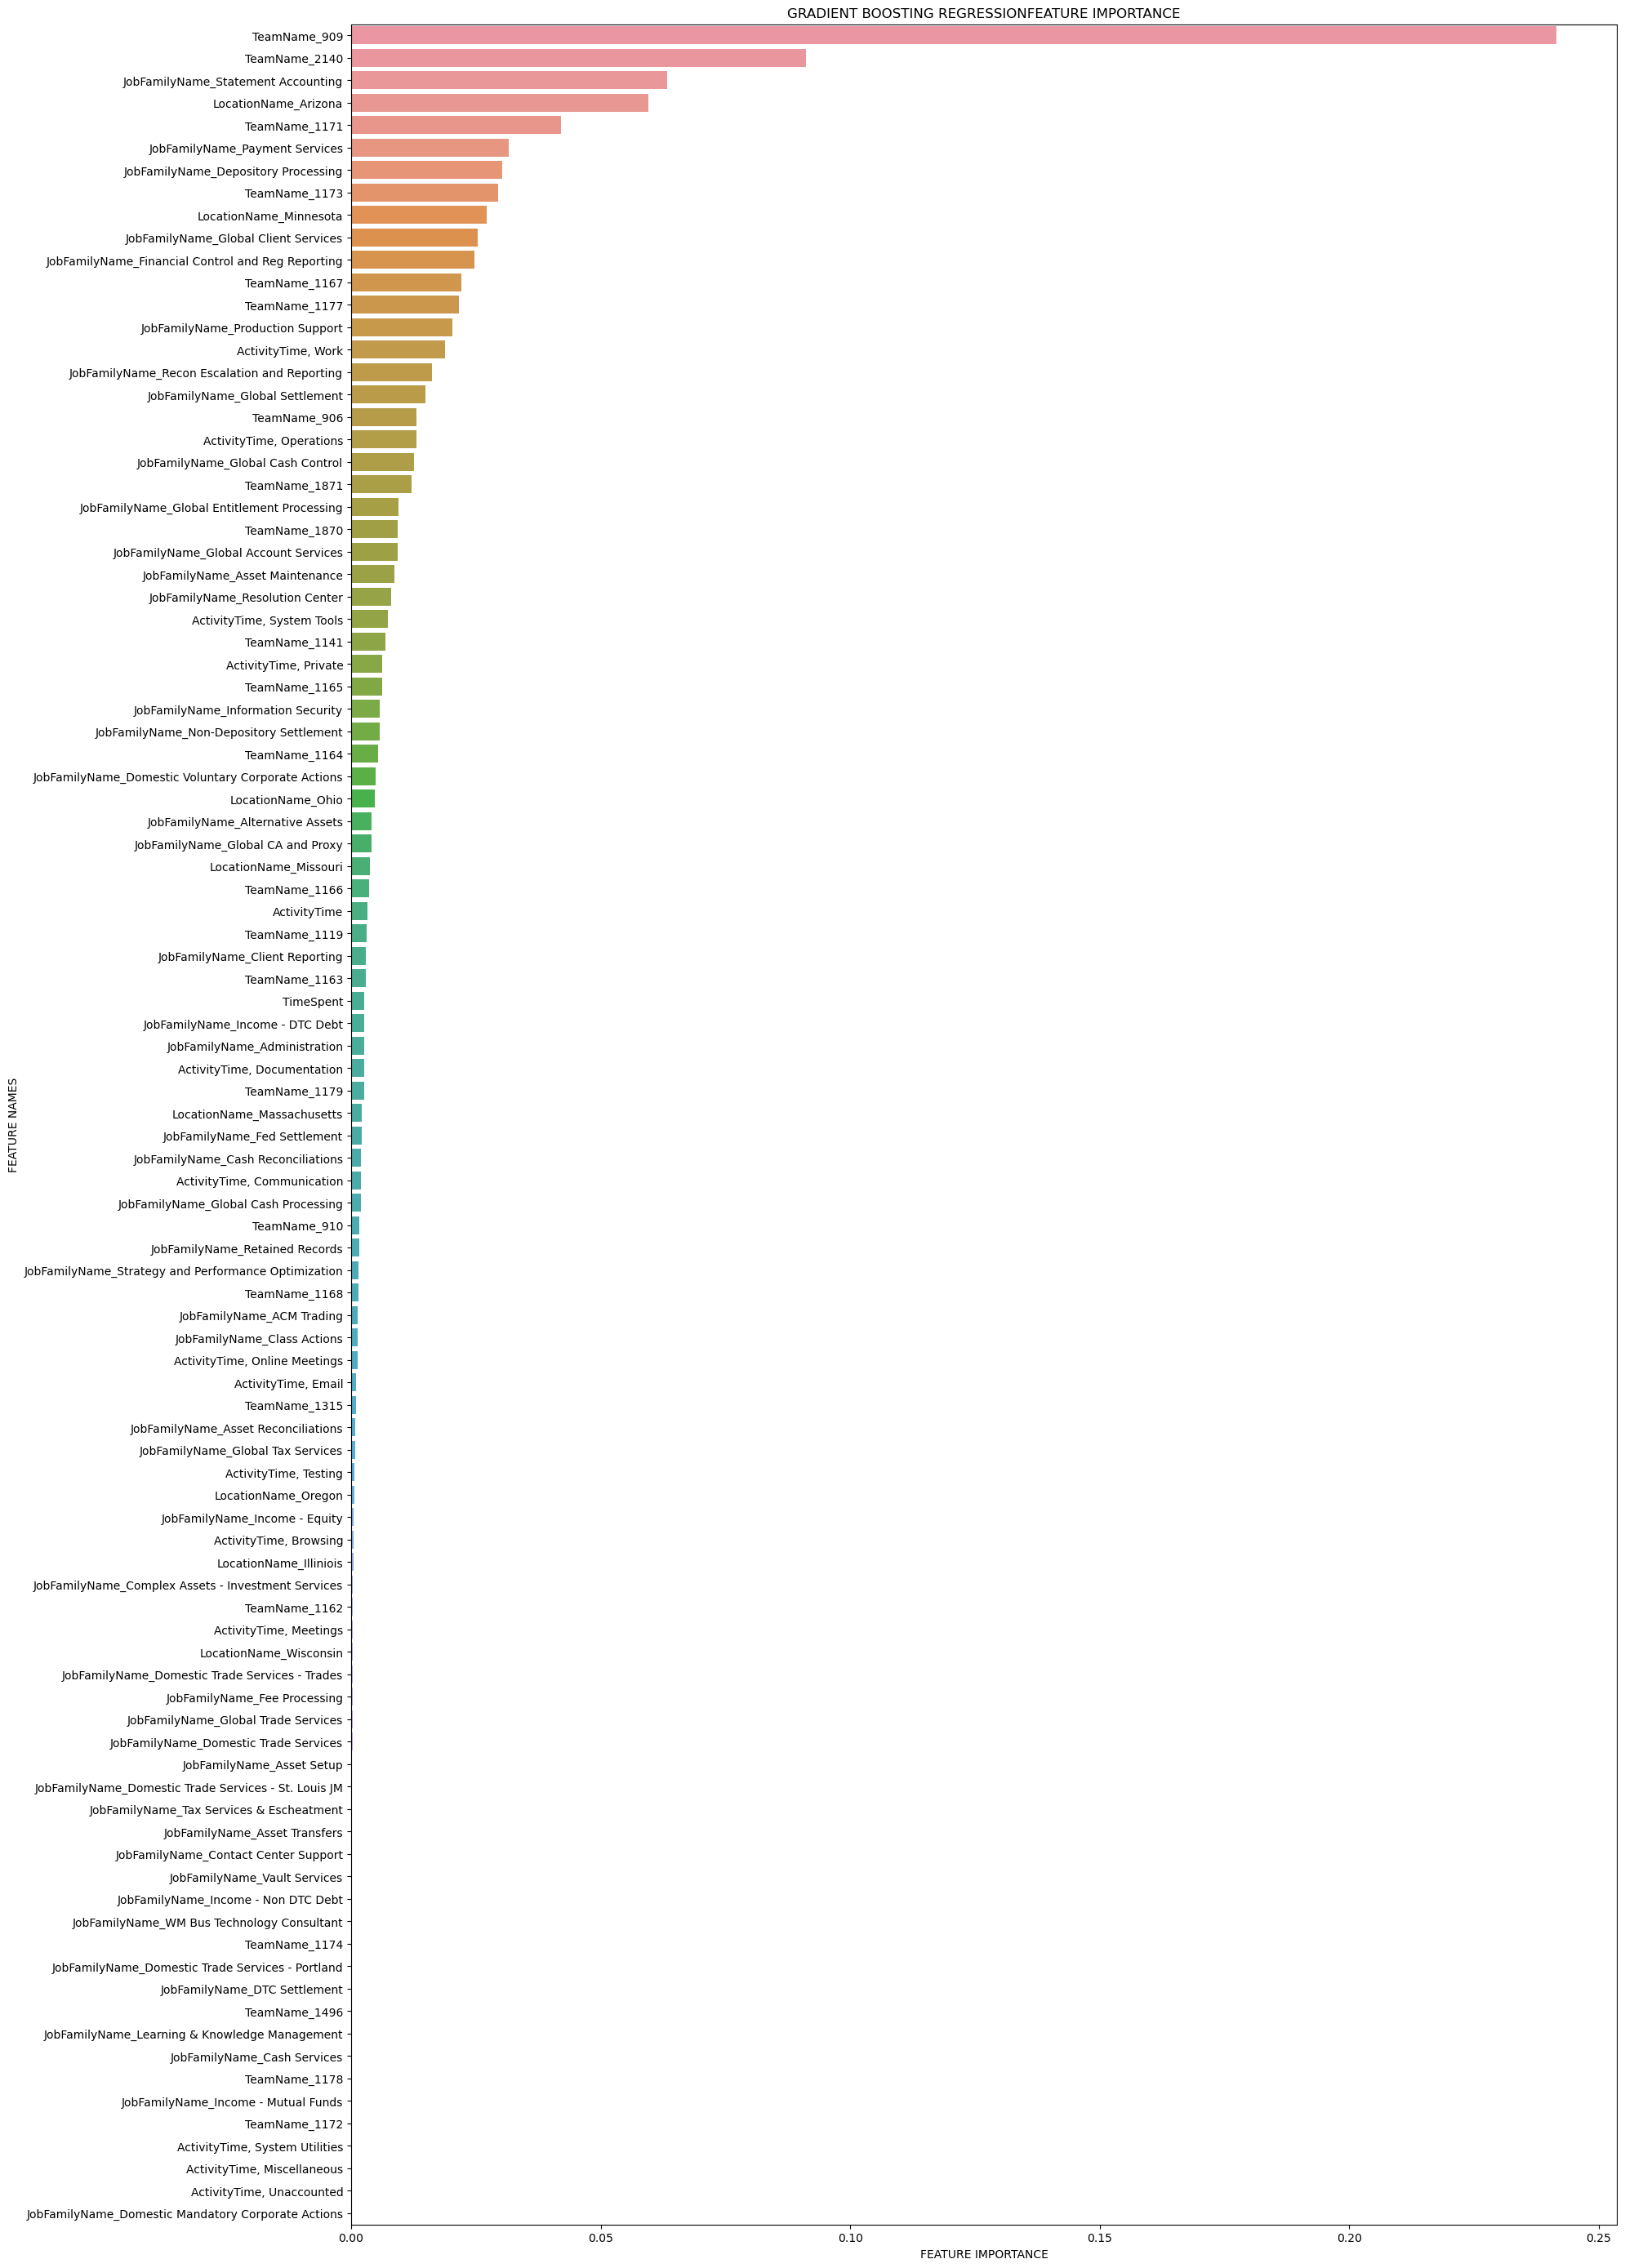

In [ ]:
##Visualize variables in feature importance
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,35))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(gb.feature_importances_,X_train.columns,'GRADIENT BOOSTING REGRESSION')

In [ ]:
feature_scores = pd.DataFrame(gb.feature_importances_, index=X_train.columns, 
                              columns = ['Importance']).sort_values('Importance', ascending = False)
feature_scores.head()

,Importance
TeamName_909,0.241525
TeamName_2140,0.091157
JobFamilyName_Statement Accounting,0.063268
LocationName_Arizona,0.059562
TeamName_1171,0.042045


In [ ]:
## Compare the the actual vs predicted values
predictions = pd.DataFrame(pred_gb)
predictions.columns = ['Predicted']
predictions.head()

,Predicted
0,203.665763
1,227.558527
2,10.357462
3,31.183863
4,124.801010


In [ ]:
actual = pd.DataFrame(y_test)
actual.columns = ['Actual']
actual.head()

,Actual
0,240
1,221
2,1
3,14
4,161


In [ ]:
## actual vs predicted
df_pred_actual = pd.concat([actual, predictions], axis=1)
df_pred_actual['Index'] = df_pred_actual.index
df_pred_actual.head()

,Actual,Predicted,Index
0,240,203.665763,0
1,221,227.558527,1
2,1,10.357462,2
3,14,31.183863,3
4,161,124.801010,4


In [ ]:
## select 60 days to termination as the cut off

df_pred_actual['difference'] = df_pred_actual['Actual'] - df_pred_actual['Predicted'] 
## calculate the difference in days to termination

cutoff = 60                             # decide on a cutoff limit which is 60 days to termination
y_pred_classes = np.zeros_like(df_pred_actual['Predicted'])    # initialise a matrix full with zeros
y_pred_classes[df_pred_actual['Predicted'] > cutoff] = 1       # add a 1 if the cutoff was breached
df_pred_actual['predicted_classes'] = y_pred_classes

y_test_classes = np.zeros_like(df_pred_actual['Actual']) ## repeat the same for actual
y_test_classes[df_pred_actual['Actual'] > cutoff] = 1
df_pred_actual['Actual_classes'] = y_test_classes
df_pred_actual.head()

,Actual,Predicted,Index,difference,predicted_classes,Actual_classes
0,240,203.665763,0,36.334237,1.0,1
1,221,227.558527,1,-6.558527,1.0,1
2,1,10.357462,2,-9.357462,0.0,0
3,14,31.183863,3,-17.183863,0.0,0
4,161,124.801010,4,36.198990,1.0,1


Text(0.5, 1.0, 'Terminated vs continuing confusion matrix (0 = terminated, 1 = continuing)')

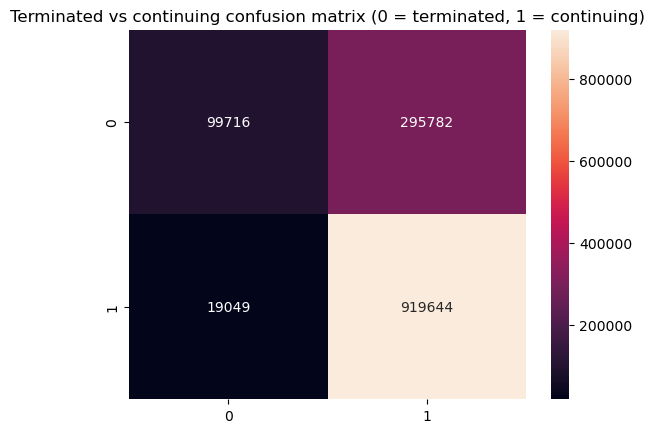

In [ ]:
## calculate the confusion matrix
cm = confusion_matrix(df_pred_actual['Actual_classes'], df_pred_actual['predicted_classes'])
sns.heatmap(cm , annot=True, fmt='d').set_title('Terminated vs continuing confusion matrix (0 = terminated, 1 = continuing)')

In [ ]:
## calculate accuracy
accuracy_score(df_pred_actual['Actual_classes'], df_pred_actual['predicted_classes'])

0.7640285386425182

In [ ]:
## calculate the recall value
recall_score(df_pred_actual['Actual_classes'], df_pred_actual['predicted_classes'])

0.9797068903251649

In [ ]:
## calculate precision
precision_score(df_pred_actual['Actual_classes'], df_pred_actual['predicted_classes'])

0.7566433497391039

In [ ]:
## calculate f1-score
f1_score(df_pred_actual['Actual_classes'], df_pred_actual['predicted_classes'])

0.8538469787416573

In [ ]:
## save
df_pred_actual.to_csv('GBRT_predict_actual_detailed.csv', index=False)
feature_scores.to_csv('GBRT_FeatureImportance_detailed.csv', index=False)